# Telco Churn

**Author:** jaume manero<br>
**Date created:** 2022/01/05<br>
**Last modified:** 2020/01/05<br>
**Description:** Telco Churn classifier <br>
    https://www.kaggle.com/blastchar/telco-customer-churn


In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.ticker as mtick 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.set(style = 'white')

import os
print(os.listdir("./"))

from xgboost import XGBClassifier



['.ipynb_checkpoints', '02_telco-churn-prediction.ipynb', '01_K-means.ipynb', 'customer-segmentation-k-means-analysis.ipynb', 'WA_Fn-UseC_-Telco-Customer-Churn.csv', 'Mall_Customers.csv']


In [ ]:
def heatmap(actual, preds, classifier):

   cf_matrix = confusion_matrix(actual, preds, labels=[1,0])
   ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

   ax.set_title('Churn Classifier -'+classifier+'\n')
   ax.set_xlabel('\nPredicted Values')
   ax.set_ylabel('Actual Values ')

   ## Ticket labels - List must be in alphabetical order
   ax.xaxis.set_ticklabels(['False','True'])
   ax.yaxis.set_ticklabels(['False','True'])

   ## Display the visualization of the Confusion Matrix.
   plt.show()
   return
                
heatmap(y_test, preds, 'XGBOOST')

In [2]:
df_cust = pd.read_csv('./WA_Fn-UseC_-Telco-Customer-Churn.csv')

### Data exploration

In [3]:
print('df_cust shape',df_cust.shape)
df_cust.dtypes

df_cust shape (7043, 21)


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [4]:
print(df_cust['TotalCharges'])
#df_cust is type object but has an amount
# Converting Total Charges to a numerical data type.
df_cust.TotalCharges = pd.to_numeric(df_cust.TotalCharges, errors='coerce')
df_cust.isnull().sum()

0         29.85
1        1889.5
2        108.15
3       1840.75
4        151.65
         ...   
7038     1990.5
7039     7362.9
7040     346.45
7041      306.6
7042     6844.5
Name: TotalCharges, Length: 7043, dtype: object


customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

After looking at the above output, we can say that there are 11 missing values for Total Charges. Let us replace remove these 11 rows from our data set

In [5]:
#Removing missing values 
df_cust.dropna(inplace = True)
#Remove customer IDs from the data set
df2 = df_cust.iloc[:,1:]
#Convertin the predictor variable in a binary numeric variable
df2['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df2['Churn'].replace(to_replace='No',  value=0, inplace=True)

#Let's convert all the categorical variables into dummy variables
df_dummies = pd.get_dummies(df2)
df_dummies.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


<AxesSubplot:>

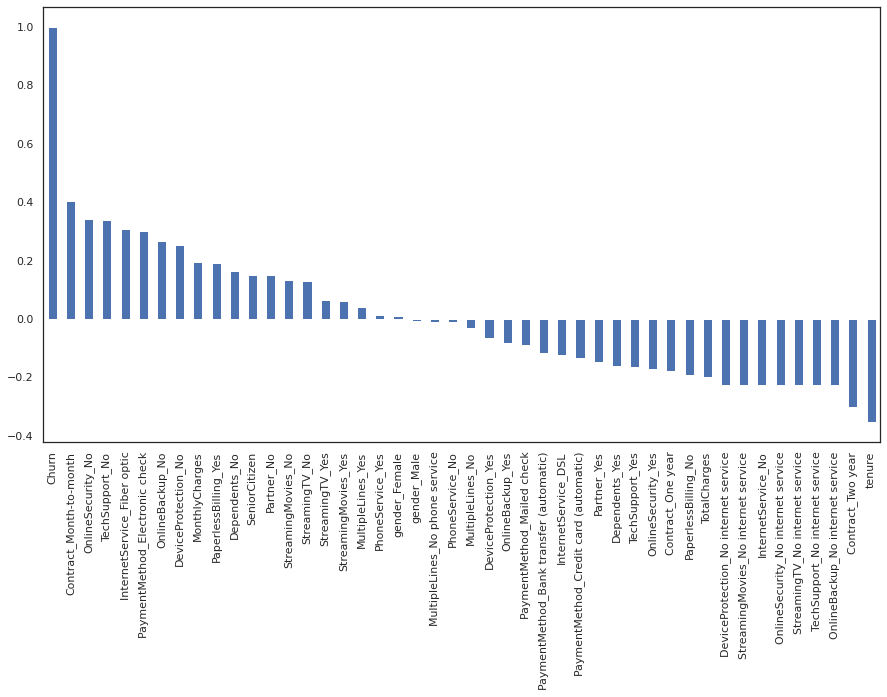

In [6]:
#Get Correlation of "Churn" with other variables:
plt.figure(figsize=(15,8))
df_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

Month to month contracts, absence of online security and tech support seem to be positively correlated with churn. While, tenure, two year contracts seem to be negatively correlated with churn. 

Interestingly, services such as Online security, streaming TV, online backup, tech support, etc. without internet connection seem to be negatively related to churn.

We will explore the patterns for the above correlations below before we delve into modelling and identifying the important variables.

## Data Exploration

Let us first start with exploring our data set, to better understand the patterns in the data and potentially form some hypothesis. First we will look at the distribution of individual variables and then slice and dice our data for any interesting trends.

**A.)** ***Demographics*** - Let us first understand the gender, age range, patner and dependent status of the customers

1. **Gender Distribution** - About half of the customers in our data set are male while the other half are female

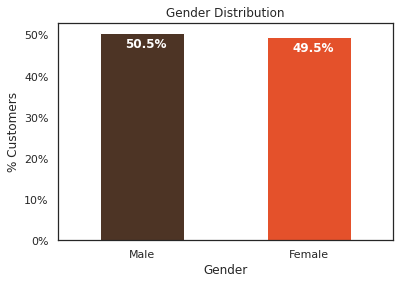

In [7]:
colors = ['#4D3425','#E4512B']
ax = (df_cust['gender'].value_counts()*100.0 /len(df_cust)).plot(kind='bar',
                                                                           stacked = True,
                                                                          rot = 0,
                                                                          color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers')
ax.set_xlabel('Gender')
ax.set_ylabel('% Customers')
ax.set_title('Gender Distribution')

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-3.5, \
            str(round((i.get_height()/total), 1))+'%',
            fontsize=12,
            color='white',
           weight = 'bold')

2. **% Senior Citizens** - There are only 16% of the customers who are senior citizens. Thus most of our customers in the data are younger people.


Text(0.5, 1.0, '% of Senior Citizens')

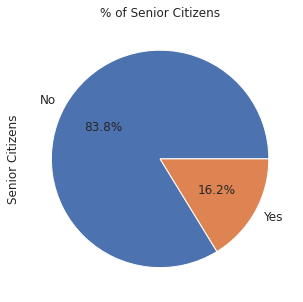

In [8]:
ax = (df_cust['SeniorCitizen'].value_counts()*100.0 /len(df_cust))\
.plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(5,5), fontsize = 12 )                                                                           
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Senior Citizens',fontsize = 12)
ax.set_title('% of Senior Citizens', fontsize = 12)

3. **Partner and dependent status**  - About 50% of the customers have a partner, while only 30% of the total customers have dependents. 

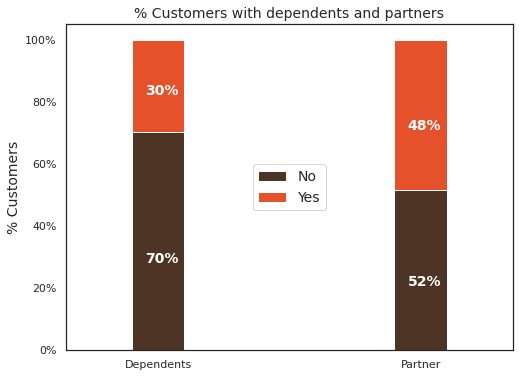

In [9]:
df2 = pd.melt(df_cust, id_vars=['customerID'], value_vars=['Dependents','Partner'])
df3 = df2.groupby(['variable','value']).count().unstack()
df3 = df3*100/len(df_cust)
colors = ['#4D3425','#E4512B']
ax = df3.loc[:,'customerID'].plot.bar(stacked=True, color=colors,
                                      figsize=(8,6),rot = 0,
                                     width = 0.2)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers',size = 14)
ax.set_xlabel('')
ax.set_title('% Customers with dependents and partners',size = 14)
ax.legend(loc = 'center',prop={'size':14})

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

**What would be interesting is to look at the % of customers, who have partners, also have dependents. We will explore this next. **

Interestingly,  among the customers who have a partner, only about half of them also have a dependent, while other half do not have any independents. 
Additionally, as expected, among the customers who do not have any partner, a majority (80%) of them do not have any dependents .

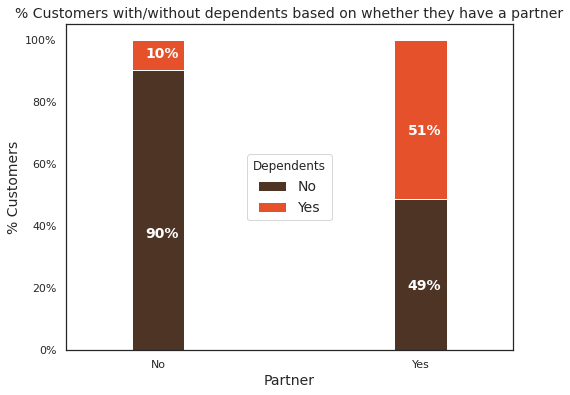

In [10]:
colors = ['#4D3425','#E4512B']
partner_dependents = df_cust.groupby(['Partner','Dependents']).size().unstack()

ax = (partner_dependents.T*100.0 / partner_dependents.T.sum()).T.plot(kind='bar',
                                                                width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (8,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center',prop={'size':14},title = 'Dependents',fontsize =14)
ax.set_ylabel('% Customers',size = 14)
ax.set_title('% Customers with/without dependents based on whether they have a partner',size = 14)
ax.xaxis.label.set_size(14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

I also looked at any differences between the % of customers with/without dependents and partners by gender. There is no difference in their distribution by gender. Additionally, there is no difference in senior citizen status by gender.

### B.) **Customer Account Information**:  Let u now look at the tenure, contract

**1. Tenure:**  After looking at the below histogram we can see that a lot of customers have been with the telecom company for just a month, while quite a many are there for about 72 months. This could be potentially because different customers have different contracts. Thus based on the contract they are into it could be more/less easier for the customers to stay/leave the telecom company.

/home/manero/retail/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, '# of Customers by their tenure')

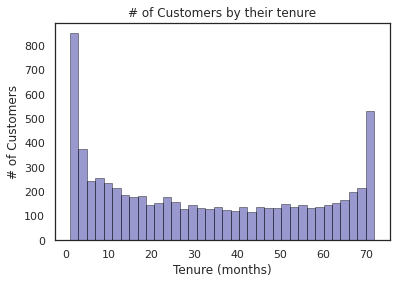

In [11]:
ax = sns.distplot(df_cust['tenure'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('# of Customers')
ax.set_xlabel('Tenure (months)')
ax.set_title('# of Customers by their tenure')

**2. Contracts:** To understand the above graph, lets first look at the # of customers by different contracts. 

Text(0.5, 1.0, '# of Customers by Contract Type')

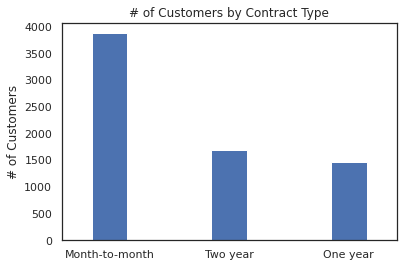

In [12]:
ax = df_cust['Contract'].value_counts().plot(kind = 'bar',rot = 0, width = 0.3)
ax.set_ylabel('# of Customers')
ax.set_title('# of Customers by Contract Type')

As we can see from this graph most of the customers are in the month to month contract. While there are equal number of customers in the 1 year and 2 year contracts.



Below we will understand the tenure of customers based on their contract type.

Text(0.5, 1.0, 'Two Year Contract')

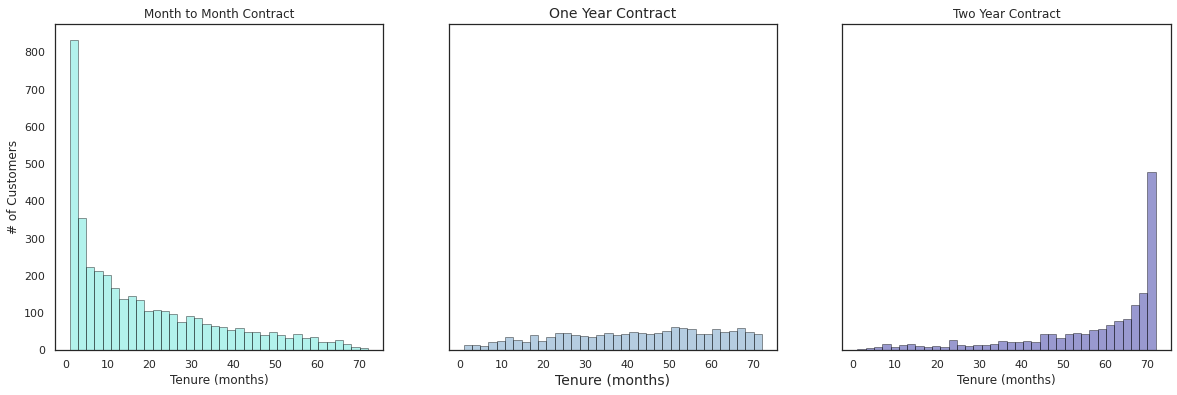

In [13]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey = True, figsize = (20,6))

ax = sns.distplot(df_cust[df_cust['Contract']=='Month-to-month']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'turquoise',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax1)
ax.set_ylabel('# of Customers')
ax.set_xlabel('Tenure (months)')
ax.set_title('Month to Month Contract')

ax = sns.distplot(df_cust[df_cust['Contract']=='One year']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'steelblue',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax2)
ax.set_xlabel('Tenure (months)',size = 14)
ax.set_title('One Year Contract',size = 14)

ax = sns.distplot(df_cust[df_cust['Contract']=='Two year']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'darkblue',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax3)

ax.set_xlabel('Tenure (months)')
ax.set_title('Two Year Contract')

Interestingly most of the monthly contracts last for 1-2 months, while the 2 year contracts tend to last for about 70 months. This shows that the customers taking a longer contract are more loyal to the company and tend to stay with it for a longer period of time. 

This is also what we saw in the earlier chart on correlation with the churn rate. 

###  C. Let us now look at the distribution of various services used by customers

In [14]:

df_cust.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

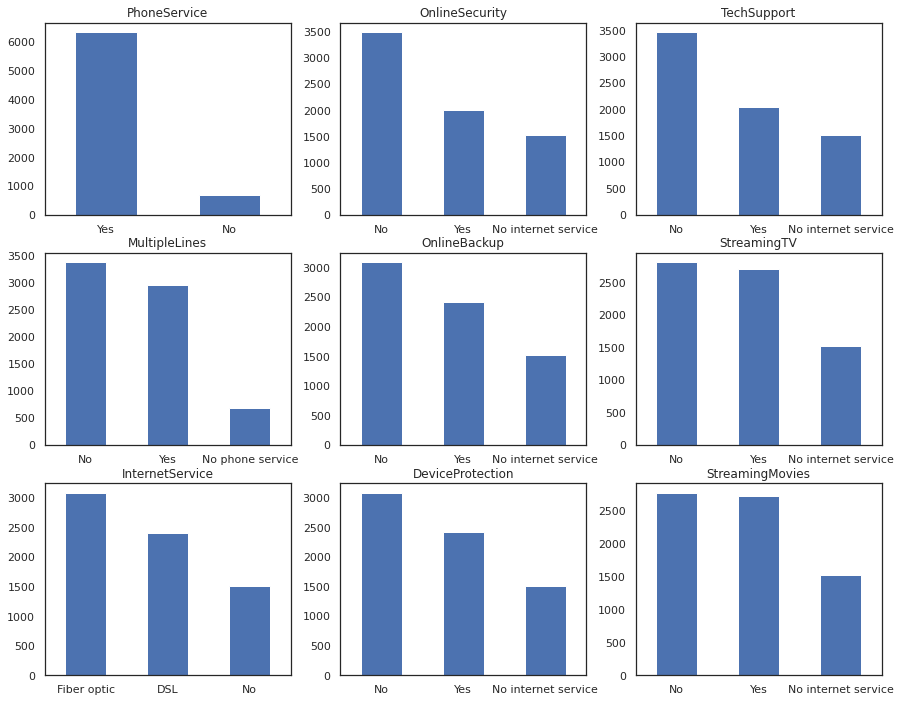

In [15]:
services = ['PhoneService','MultipleLines','InternetService','OnlineSecurity',
           'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

fig, axes = plt.subplots(nrows = 3,ncols = 3,figsize = (15,12))
for i, item in enumerate(services):
    if i < 3:
        ax = df_cust[item].value_counts().plot(kind = 'bar',ax=axes[i,0],rot = 0)
        
    elif i >=3 and i < 6:
        ax = df_cust[item].value_counts().plot(kind = 'bar',ax=axes[i-3,1],rot = 0)
        
    elif i < 9:
        ax = df_cust[item].value_counts().plot(kind = 'bar',ax=axes[i-6,2],rot = 0)
    ax.set_title(item)

### D.) Now let's take a quick look at the relation between monthly and total charges

We will observe that the total charges increases as the monthly bill for a customer increases.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='MonthlyCharges', ylabel='TotalCharges'>

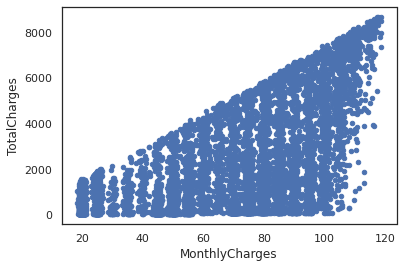

In [16]:
df_cust[['MonthlyCharges', 'TotalCharges']].plot.scatter(x = 'MonthlyCharges',
                                                              y='TotalCharges')

### E.) Finally, let's take a look at out predictor variable (Churn) and understand its interaction with other important variables as was found out in the correlation plot. 

1. Lets first look at the churn rate in our data

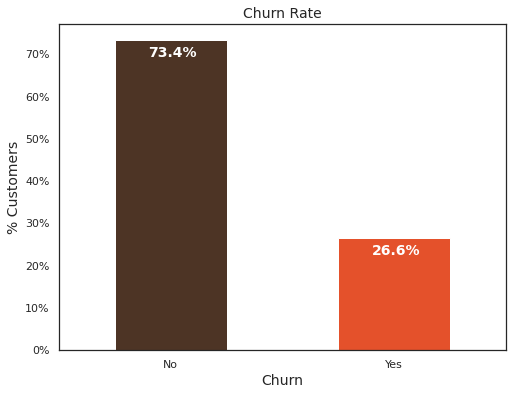

In [17]:
colors = ['#4D3425','#E4512B']
ax = (df_cust['Churn'].value_counts()*100.0 /len(df_cust)).plot(kind='bar',
                                                                           stacked = True,
                                                                          rot = 0,
                                                                          color = colors,
                                                                         figsize = (8,6))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers',size = 14)
ax.set_xlabel('Churn',size = 14)
ax.set_title('Churn Rate', size = 14)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-4.0, \
            str(round((i.get_height()/total), 1))+'%',
            fontsize=12,
            color='white',
           weight = 'bold',
           size = 14)

In our data, 74% of the customers do not churn. Clearly the data is skewed as we would expect a large majority of the customers to not churn. This is important to keep in mind for our modelling as skeweness could lead to a lot of false negatives. We will see in the modelling section on how to avoid skewness in the data.

2. Lets now explore the churn rate by tenure, seniority, contract type, monthly charges and total charges to see how it varies by these variables.

**i.) Churn vs Tenure**: As we can see form the below plot, the customers who do not churn, they tend to stay for a longer tenure with the telecom company. 

<AxesSubplot:xlabel='Churn', ylabel='tenure'>

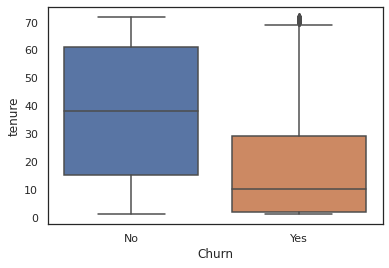

In [18]:
sns.boxplot(x = df_cust.Churn, y = df_cust.tenure)

**ii.) Churn by Contract Type**: Similar to what we saw in the correlation plot, the customers who have a month to month contract have a very high churn rate.

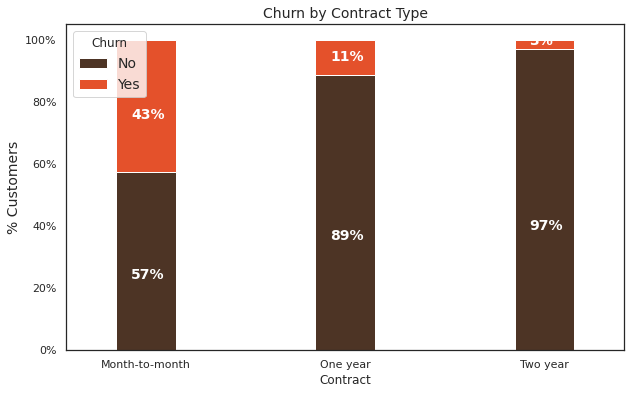

In [19]:
colors = ['#4D3425','#E4512B']
contract_churn = df_cust.groupby(['Contract','Churn']).size().unstack()

ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (10,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers',size = 14)
ax.set_title('Churn by Contract Type',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

**iii.) Churn by Seniority**: Senior Citizens have almost double the churn rate than younger population.

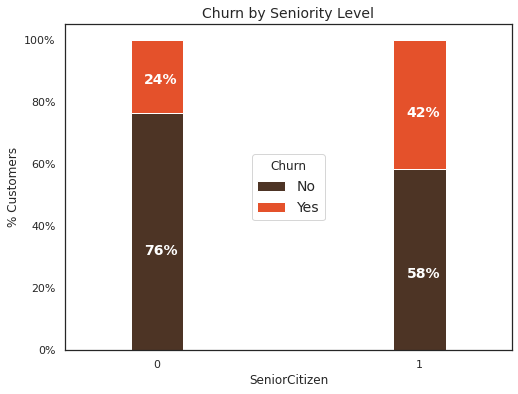

In [20]:
colors = ['#4D3425','#E4512B']
seniority_churn = df_cust.groupby(['SeniorCitizen','Churn']).size().unstack()

ax = (seniority_churn.T*100.0 / seniority_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (8,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers')
ax.set_title('Churn by Seniority Level',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',size =14)

**iv.) Churn by Monthly Charges**: Higher % of customers churn when the monthly charges are high.

Text(0.5, 1.0, 'Distribution of monthly charges by churn')

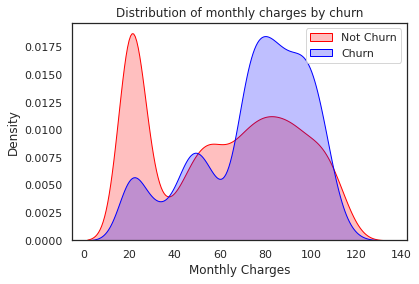

In [21]:
ax = sns.kdeplot(df_cust.MonthlyCharges[(df_cust["Churn"] == 'No') ],
                color="Red", shade = True)
ax = sns.kdeplot(df_cust.MonthlyCharges[(df_cust["Churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of monthly charges by churn')

**v.) Churn by Total Charges**: It seems that there is higer churn when the total charges are lower.

Text(0.5, 1.0, 'Distribution of total charges by churn')

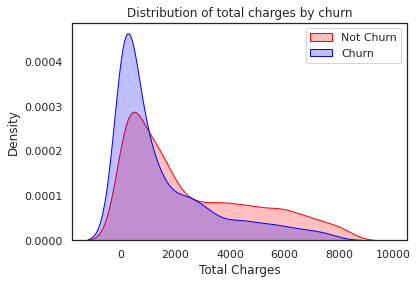

In [22]:
ax = sns.kdeplot(df_cust.TotalCharges[(df_cust["Churn"] == 'No') ],
                color="Red", shade = True)
ax = sns.kdeplot(df_cust.TotalCharges[(df_cust["Churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Total Charges')
ax.set_title('Distribution of total charges by churn')